In [38]:
# 模型预测
import os

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from PIL import Image

DIR_INPUT = '/home/bright/kaggle/global_weater/data'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'

WEIGHTS_FILE = 'fasterrcnn_resnet50_fpn_weater.pth'

In [39]:
test_df = pd.read_csv(f'{DIR_INPUT}/sample_submission.csv')
test_df.tail()

,image_id,PredictionString
5,348a992bb,1.0 0 0 50 50
6,cc3532ff6,1.0 0 0 50 50
7,2fd875eaa,1.0 0 0 50 50
8,cb8d261a3,1.0 0 0 50 50
9,53f253011,1.0 0 0 50 50


In [40]:
import cv2 as cv
import numpy as np

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
from torch.utils.data import Dataset


class WheatTest(Dataset):

  def __init__(self, image_ids, image_dir, transforms=None):
    super().__init__()
    self.image_ids = image_ids
    self.image_dir = image_dir
    self.transforms = transforms

  def __getitem__(self, idx: int):
    image_id = self.image_ids[idx]

    image = cv.imread(f'{self.image_dir}/{image_id}.jpg', cv.IMREAD_COLOR)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.0

    if self.transforms:
      sample = {
        'image': image,
      }
      sample = self.transforms(**sample)
      image = sample['image']

    return image, image_id

  def __len__(self) -> int:
    return len(self.image_ids)

  @staticmethod
  def get_test_transform():
    return A.Compose([
      ToTensorV2(p=1.0)
    ])

In [41]:
def get_image_ids(p):
  import glob
  image_ids = []
  for p in glob.glob(f'{p}/*.jpg'):
    n, _ = os.path.splitext(os.path.basename(p))
    image_ids.append(n)
  return image_ids

# try more images for submission
#test_dataset = WheatTest(get_image_ids(DIR_TRAIN), DIR_TRAIN, WheatTest.get_test_transform())

test_dataset = WheatTest(test_df["image_id"].unique(), DIR_TEST, WheatTest.get_test_transform())

In [42]:
from torch.utils.data import DataLoader

def collate_fn(batch):
  return tuple(zip(*batch))

test_data_loader = DataLoader(
  test_dataset,
  batch_size=2,
  shuffle=False,
  num_workers=4,
  drop_last=False,
  collate_fn=collate_fn
)

In [43]:
# 载入模型
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# create a Faster R-CNN model without pre-trained
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=False)

num_classes = 2 # wheat or not(background)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained model's head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# load the trained weights
model.load_state_dict(torch.load(WEIGHTS_FILE, map_location=device))
model.eval()

# move model to the right device
_ = model.to(device)

In [44]:
score_threshold = 0.7
image_outputs = []

for images, image_ids in test_data_loader:
  images = list(image.to(device) for image in images)
  outputs = model(images)

  for image_id, output in zip(image_ids, outputs):
    boxes = output['boxes'].data.cpu().numpy()
    scores = output['scores'].data.cpu().numpy()

    mask = scores >= score_threshold
    boxes = boxes[mask].astype(np.int32)
    scores = scores[mask]

    image_outputs.append((image_id, boxes, scores))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


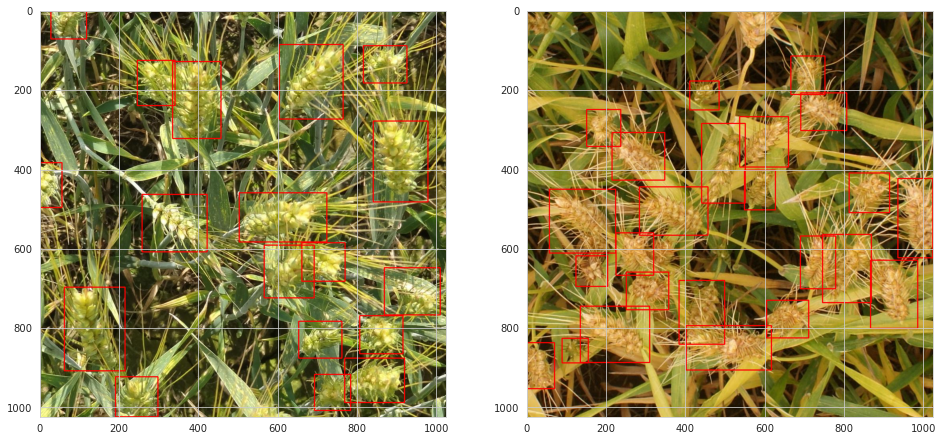

In [45]:
num_rows, num_cols = 1, 2
scale = 16
figsize = (num_rows * scale, num_cols * scale)
_, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
axes = axes.flatten()

fig_n = num_rows * num_cols
fig_i = 0

for i in range(1, 1+fig_n):
  image, image_id = test_dataset[i]
  _, boxes, scores = image_outputs[i]

  sample = image.permute(1, 2, 0).cpu().numpy()

  for box in boxes:
    cv.rectangle(sample, (box[0], box[1]), (box[2], box[3]), (220, 0, 0), 2)

  axes[fig_i].imshow(sample)
  fig_i += 1

In [46]:
def format_prediction_string(boxes, scores):
  pred_strings = []
  for score, box in zip(scores, boxes):
    pred_strings.append(round(score, 4))
    pred_strings.extend(box)
  return ' '.join(map(str, pred_strings))

results = []

for image_id, boxes, scores in image_outputs:
  #boxes = boxes_.copy()
  boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
  boxes[:, 3] = boxes[:, 3] - boxes[:, 1]

  result = {
    'image_id': image_id,
    'PredictionString': format_prediction_string(boxes, scores)
  }
  results.append(result)

results[0]

{'image_id': 'aac893a91',
 'PredictionString': '0.9992 69 0 104 165 0.9979 553 536 137 190 0.9977 690 388 133 178 0.9965 238 84 143 154 0.9965 615 928 80 96 0.9964 324 667 129 160 0.9958 24 451 112 160 0.9946 538 56 155 203 0.9936 737 776 81 108 0.9927 170 562 121 192 0.9915 359 531 97 84 0.9833 590 782 99 114 0.9784 816 694 109 223 0.9717 453 859 86 105 0.9716 237 844 169 115 0.9697 353 261 129 165 0.9592 308 0 72 67 0.9179 96 617 117 93 0.9038 819 630 92 127 0.8508 60 855 120 75'}

In [47]:
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df

,image_id,PredictionString
0,aac893a91,0.9992 69 0 104 165 0.9979 553 536 137 190 0.9...
1,51f1be19e,0.9975 603 84 161 188 0.9973 61 696 153 211 0....
2,f5a1f0358,0.9973 935 422 88 200 0.9962 689 567 89 133 0....
3,796707dd7,0.9935 706 825 115 107 0.9928 895 327 112 99 0...
4,51b3e36ab,0.9992 233 647 94 159 0.9982 834 445 190 164 0...
5,348a992bb,0.9961 914 568 89 91 0.996 2 318 114 99 0.9952...
6,cc3532ff6,0.9988 768 819 175 172 0.998 548 833 143 178 0...
7,2fd875eaa,0.9979 464 358 131 97 0.9975 455 496 82 147 0....
8,cb8d261a3,0.9935 305 165 116 205 0.9886 19 862 84 142 0....
9,53f253011,0.9977 620 103 123 154 0.9972 928 809 96 203 0...


In [48]:
test_df.to_csv('submission.csv', index=False)